# Exploring Centroids Classification Via PyTorch and Scikit-Learn

- Using PyTorch implementation of ResNet50 to get embeddings
- Using Scikit-Learn k-means clustering to get centroids of each class
- Using Scikit-Learn's knn clasifier to fit the centroids and for inference
- Using Matplotlib to visualise the centroids on a 2D space

### Initialisation

Import required packages.

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import ResNet50_Weights, resnet50
import torchvision.transforms as transforms
from PIL import Image
from io import BytesIO
import os
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import joblib
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import json

Load ResNet50 with default weights.

In [37]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model = torch.nn.Sequential(*list(model.children())[:-1])
print(ResNet50_Weights.DEFAULT)

ResNet50_Weights.IMAGENET1K_V2


Save model weights so that web app can load from S3 next time.

In [38]:
model_name = "../model/resnet50_default_embedder.pth"
torch.save(model.state_dict(), model_name)

Test loading of weights.

In [39]:
model = torch.nn.Sequential(*list(resnet50().children())[:-1])
loaded_state_dict = torch.load(model_name)
model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

Define image transformation function.

In [40]:
def transform_image(image_bytes: bytes):
    # Default unchanged mean and std
    # mean = [0.5, 0.5, 0.5]
    # std = [0.5, 0.5, 0.5]

    # Imagenet mean and std
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    transform_output = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ]
    )
    image = Image.open(BytesIO(image_bytes)).convert("RGB")
    return transform_output(image).float().unsqueeze(0)

Test feature extraction.

In [41]:
with open("../data/mock_s3_train/tench/n01440764_1009.JPEG", "rb") as f:
    image_bytes = f.read()

img = transform_image(image_bytes)
img_features = model(img)

print(img.shape)
print(img_features.shape)
print(img_features.squeeze().shape)
print(img_features.squeeze())

torch.Size([1, 3, 224, 224])
torch.Size([1, 2048, 1, 1])
torch.Size([2048])
tensor([0.0390, 0.0876, 0.0322,  ..., 0.1154, 0.0867, 0.0668],
       grad_fn=<SqueezeBackward0>)


### Get Centroids via K-Means

Get image features for all images in folder and stack them.

In [43]:
model.eval() #Important
folder_name = "../data/mock_s3_train/tench"
all_img_features_list = []
for image_filename in os.listdir(folder_name):
    with open(f"{folder_name}/{image_filename}", "rb") as f:
        image_bytes = f.read()
    img = transform_image(image_bytes)
    img_features = model(img).squeeze()
    all_img_features_list.append(img_features)

all_img_features = torch.stack(all_img_features_list)
print(all_img_features.shape)

torch.Size([100, 2048])


Define k-means model.

In [44]:
# Variables to consider saving in S3 together with PyTorch ResNet50 model
num_centroids = 30
random_state = 2023
kmeans = KMeans(n_clusters=num_centroids, random_state=random_state, init='k-means++', n_init=1)
kmeans.fit(all_img_features.detach().numpy())
print(kmeans.cluster_centers_.shape)

(30, 2048)


Make the above into a reusable function.

In [45]:
def get_centroids(folder_name: str, num_centroids: int, random_state: int):
    # Below section to be modified to retrieve images from S3
    all_img_features_list = []
    for image_filename in os.listdir(f"{folder_name}"):
        with open(f"{folder_name}/{image_filename}", "rb") as f:
            image_bytes = f.read()
        img = transform_image(image_bytes)
        img_features = model(img).squeeze()
        all_img_features_list.append(img_features)

    all_img_features = torch.stack(all_img_features_list)
    kmeans = KMeans(n_clusters=num_centroids, random_state=random_state, init='k-means++', n_init=1)
    kmeans.fit(all_img_features.detach().numpy())
    return kmeans.cluster_centers_

Get centroids for both folders.

In [46]:
all_centroids_dict = {}

for folder_name in ["tench", "coucal"]:
    all_centroids_dict[folder_name] = get_centroids(f"../data/mock_s3_train/{folder_name}", num_centroids, random_state)

print(all_centroids_dict["tench"].shape)
print(all_centroids_dict["coucal"].shape)
print(all_centroids_dict["tench"][0])
print(all_centroids_dict["coucal"][0])

(30, 2048)
(30, 2048)
[0.04882131 0.         0.03448014 ... 0.00260307 0.03191869 0.00851635]
[0.0344649 0.        0.        ... 0.        0.        0.       ]


Save centroids as joblib file.

In [47]:
joblib.dump(all_centroids_dict, "../model/all_centroids_dict.joblib")

['../model/all_centroids_dict.joblib']

Load centroids from joblib file to test.

In [48]:
all_centroids_dict = joblib.load("../model/all_centroids_dict.joblib")

print(all_centroids_dict["tench"].shape)
print(all_centroids_dict["coucal"].shape)
print(all_centroids_dict["tench"][0])
print(all_centroids_dict["coucal"][0])

(30, 2048)
(30, 2048)
[0.04882131 0.         0.03448014 ... 0.00260307 0.03191869 0.00851635]
[0.0344649 0.        0.        ... 0.        0.        0.       ]


### Train KNN Classifier on Centroids

Define knn classifier model.

In [49]:
num_neighbours = 5
knn = KNeighborsClassifier(n_neighbors=num_neighbours)

Fit knn to centroids.

In [50]:
X = []
y = []

for key in all_centroids_dict.keys():
    print(key)
    X.append(all_centroids_dict[key])
    y.append([key] * len(all_centroids_dict[key]))

X = np.concatenate(X)
y = np.concatenate(y)

print(X.shape)
print(y.shape)

knn.fit(X, y)

tench
coucal
(60, 2048)
(60,)


KNeighborsClassifier()

Test model inference.

In [51]:
test_img_feature = img_features.detach().numpy().reshape(1, -1)
print(knn.predict(test_img_feature))
print(knn.predict_proba(test_img_feature))

['tench']
[[0. 1.]]


Save classifier as joblib file.

In [52]:
joblib.dump(knn, "../model/knn.joblib")

['../model/knn.joblib']

Load classifier from joblib file to test.

In [53]:
knn = joblib.load("../model/knn.joblib")
print(knn.predict(test_img_feature))
print(knn.predict_proba(test_img_feature))

['tench']
[[0. 1.]]


### Test Batch Evaluation

Copying single inference function that is already done from `helper_model.py` to cell below.

In [54]:
def get_prediction(model_dict: dict, image_bytes: bytes):
    class_names = model_dict["classifier"].classes_
    img = transform_image(image_bytes=image_bytes)
    model_dict["feature_extractor"].eval()
    with torch.no_grad():
        img_features = model_dict["feature_extractor"](img)
        img_features = img_features.detach().numpy().reshape(1, -1)
        pred_probas = model_dict["classifier"].predict_proba(img_features)[0]
        predicted_classes = {
            predicted_class: confidence
            for (predicted_class, confidence) in zip(class_names, pred_probas)
        }
        predicted_classes = {
            key: value
            for (key, value) in sorted(
                predicted_classes.items(), key=lambda x: x[1], reverse=True
            )
        }
        top_predictions = {
            key: value for (key, value) in list(predicted_classes.items())[:5]
        }
    return top_predictions

Quick testing of function.

In [55]:
get_prediction({
    "feature_extractor": model,
    "classifier": knn
}, image_bytes)

{'tench': 1.0, 'coucal': 0.0}

Code logic for looping through zip file and performing inference for image files that have no issues. Mini evaluation will be done to categorise predictions as correct or wrong.

In [56]:
# Possible params for function
test_batch_evaluation_zip = "../data/for_zipping/test_batch_evaluation.zip"
base_folder_to_save = "../data/for_zipping"
model_dict = {
    "feature_extractor": model,
    "classifier": knn
}
top_k = 1

# Code logic for batch evaluation function
overall_prediction = {
    "top_k": top_k,
    "correct": {},
    "wrong": {},
    "skipped": {}
}
with ZipFile(test_batch_evaluation_zip, "r") as zip_ref:
    for filename in zip_ref.namelist():
        if any(filename.lower().endswith(prefix) for prefix in [".png", ".jpg", ".jpeg"]):
            try:
                with zip_ref.open(filename) as f:
                    image_bytes = f.read()
            except Exception as err:
                print(err)
                image_bytes = None
                overall_prediction["skipped"][filename] = "File could not be read."

            if image_bytes is not None:
                try:
                    predictions = get_prediction(model_dict, image_bytes)

                    #  Change logic to check top 5 predictions instead of top 1 prediction
                    #  where there are more classes
                    if any(filename.lower().startswith(suffix) for suffix in list(predictions.keys())[:top_k]):
                        overall_prediction["correct"][filename] = predictions
                    else:
                        overall_prediction["wrong"][filename] = predictions
                except Exception as err:
                    print(err)
                    overall_prediction["skipped"][filename] = "Prediction failed."
        else:
            overall_prediction["skipped"][filename] = "File extension not supported."


VIew results summary.

In [57]:
print(f" No. Correct: {len(overall_prediction['correct'])}")
print(f" No. Correct (Coucal): {len([filename for filename in overall_prediction['correct'] if filename.startswith('coucal')])}")
print(f" No. Correct (Tench): {len([filename for filename in overall_prediction['correct'] if filename.startswith('tench')])}")
print()
print(f" No. Wrong: {len(overall_prediction['wrong'])}")
print(f" No. Wrong (Coucal): {len([filename for filename in overall_prediction['wrong'] if filename.startswith('coucal')])}")
print(f" No. Wrong (Tench): {len([filename for filename in overall_prediction['wrong'] if filename.startswith('tench')])}")
print()
print(f" No. Skipped: {len(overall_prediction['skipped'])}")

 No. Correct: 56
 No. Correct (Coucal): 28
 No. Correct (Tench): 28

 No. Wrong: 0
 No. Wrong (Coucal): 0
 No. Wrong (Tench): 0

 No. Skipped: 0


See which tench images got wrong.

In [58]:
class_name = 'tench'
for filename in [filename for filename in overall_prediction['wrong'] if filename.startswith(class_name)]:
    print(filename, overall_prediction['wrong'][filename])

Making dict into json for upload into S3.

In [59]:
overall_prediction_json = json.dumps(overall_prediction, indent=4)
with open(f"{base_folder_to_save}/overall_prediction.json", "w") as f:
    f.write(overall_prediction_json)

### Visualise Centroids via 2D PCA

Define PCA.

In [60]:
pca = PCA(n_components=2)

Fit PCA for all centroids.

In [61]:
pca_X = pca.fit_transform(X)
pca_X.shape

(60, 2)

Plot PCA points on 2D plot.

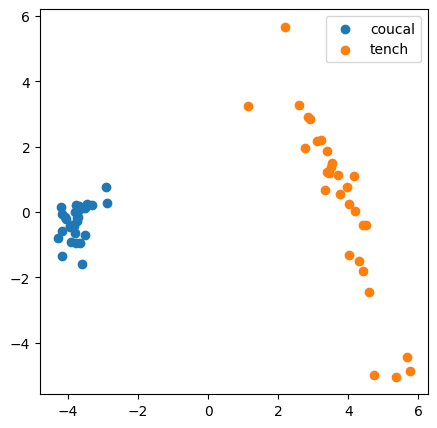

In [62]:
fig, ax = plt.subplots(figsize=(5, 5))

for label in np.unique(y):
    idx = np.where(y == label)
    ax.scatter(pca_X[idx, 0], pca_X[idx, 1], label=label)

ax.legend()
plt.show()